In [ ]:
!pip install -U langchain==0.3.24 langchain-openai==0.3.14 langgraph==0.3.33 langchain-tavily==0.1.6

In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = ### Your-key
os.environ["LANGCHAIN_PROJECT"] = "Visual-Agentic-AI"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"] = ### Your-key
os.environ["OPENAI_API_KEY"] = ### Your-key

# **Multi-agent Supervisor**

## **Research Agent**

In [ ]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

web_search_results = web_search.invoke("What is the temprature of Vietnam?")

print(web_search_results["results"][0]["content"])

In the following table, we can see the the average daily temperature by month in Vietnam. The coldest month is January, with an average of 20.8 °C (69.4 °F). The warmest month is June, with an average of 28.1 °C (82.6 °F).


In [ ]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [ ]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [ ]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_FfNNfsNG5UMJAm6q704ssQ4g)
 Call ID: call_FfNNfsNG5UMJAm6q704ssQ4g
  Args:
    query: current mayor of New York City
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "List of mayors of New York City - Wikipedia", "url": "https://en.wikipedia.org/wiki/List_of_mayors_of_New_York_City", "content": "The mayor of New York City is the chief executive of the Government of New York City, as stipulated by New York City's charter.The current officeholder, the 110th in the sequence of regular mayors, is Eric Adams, a member of the Democratic Party.. During the Dutch colonial period from 1624 to 1664, New Amsterda

## **Math Agent**

In [ ]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [ ]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_PGAozxdGMS5x7dmpybAnC5QE)
 Call ID: call_PGAozxdGMS5x7dmpybAnC5QE
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_r1Ak3NithrYQuJ6IqgUcy0S4)
 Call ID: call_r1Ak3NithrYQuJ6IqgUcy0S4
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




## **Supervisor**

In [ ]:
!pip install langgraph-supervisor

In [ ]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("gpt-4o"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

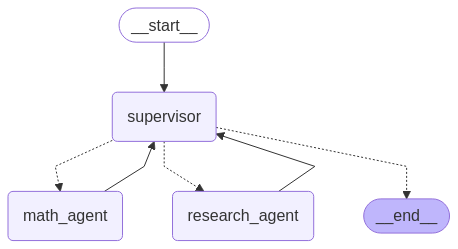

In [ ]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find GDP of Vietnam in 2023 and 2024, determine the percentage increase or decrease?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Vietnam's GDP grew from $429.72 billion in 2023 to $476.3 billion in 2024, marking an approximate increase